## Post-processing script for 3DLeafSeg

#### Last edited by: M. Jenkins
#### Date:  05.01.2018

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io
from skimage.transform import rescale
from skimage.morphology import remove_small_objects, skeletonize_3d
from skimage.measure import marching_cubes_lewiner, mesh_surface_area
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.filters import maximum_filter, median_filter, minimum_filter, percentile_filter

In [2]:
# Define filters for clipping off artefactual IAS protrusions due to dangling epidermis
def dbl_pct_filt(arr):
    out = percentile_filter(
        percentile_filter(
            arr, 
            size=30, 
            percentile=10),
        size=30,percentile=90)
    return(out)

def min_max_filt(arr):
    out = minimum_filter(
        maximum_filter(arr,20),
        20)
    return out

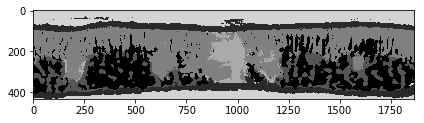

In [3]:
# Import full stack prediction from ML algorithm
filepath = '../results/'
results_folder = 'riparia'
img = io.imread(filepath+results_folder+'/fullstack_prediction.tif')
io.imshow(img[0,:,:])
io.show()

In [5]:
# define pixel values
epidermis = 42
spongy = 85
palisade = 128
ias = 0
bg = 212
vein = 170

In [21]:
np.unique(img)
print(img.shape)

(500, 432, 1864)


In [7]:
# Remove 'dangling' epidermal pixels
epid = (img==epidermis)
epid_rmv_parts = np.array(epid, copy=True)
for i in range(0,epid_rmv_parts.shape[0]):
    epid_rmv_parts[i,:,:] = remove_small_objects(epid[i,:,:], min_size=1200)

# Write an array of just the removed particles
epid_parts = epid ^ epid_rmv_parts

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img[epid_parts==1] = bg

# Do this again in another dimension
epid2 = (epid_rmv_parts==1)
epid_rmv_parts2 = np.array(epid2, copy=True)
for j in range(0,epid_rmv_parts.shape[1]):
    epid_rmv_parts2[:,j,:] = remove_small_objects(epid2[:,j,:], min_size=200)

# Write an array of just the removed particles, again
epid_parts2 = epid ^ epid_rmv_parts2

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img[epid_parts2==1] = bg

# # Free up some memory
# del epid_rmv_parts
# del epid

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


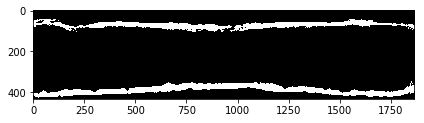

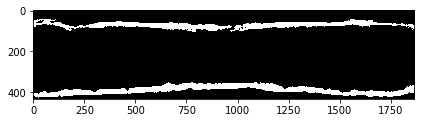

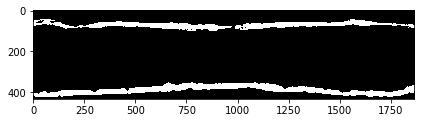

In [8]:
value = 45
io.imshow(epid[value,:,:])
io.show()
io.imshow(epid2[value,:,:])
io.show()
io.imshow(epid_rmv_parts2[value,:,:])
io.show()

In [9]:
# Define 3D array of distances from lowest value img.shape[1] to highest value
a = range(0,img.shape[1])
b = np.tile(a,(img.shape[2],img.shape[0],1))
b = np.moveaxis(b,[0,1,2],[2,0,1])

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


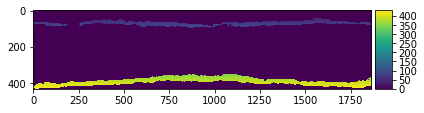

In [10]:
io.imshow(b[0,:,:]*epid_rmv_parts2[10,:,:])
io.show()

In [11]:
# Determine the lower edge of the spongy mesophyll
c = (img==spongy)
d = (b*c)
s_low = np.argmax(d, axis=1)
s_low_adjust = np.array(s_low, copy=True)
s_low_adjust[(s_low==img.shape[1])] = 0

# Determine the lower edge of the palisade mesophyll
c = (img==palisade)
d = (b*c)
p_low = np.argmax(d, axis=1)
p_low_adjust = np.array(p_low, copy=True)
p_low_adjust[(p_low==img.shape[1])] = 0
        
# Determine the lower edge of the vein
c = (img==vein)
d = (b*c)
v_low = np.argmax(d, axis=1)
v_low_adjust = np.array(v_low, copy=True)
v_low_adjust[(v_low==img.shape[1])] = 0

# Determine the lower edge of the ias
c = (img==ias)
d = (b*c)
ias_low = np.argmax(d, axis=1)
ias_low_adjust = np.array(ias_low, copy=True)
ias_low_adjust[(ias_low==img.shape[1])] = 0

# Determine the lower edge of the epidermis
c = (img==epidermis)
d = (b*c)
e_low = np.argmax(d, axis=1)
# e_low_adjust = np.array(e_low, copy=True)
# e_low_adjust[(e_low==img.shape[1])] = 0

e_low = np.maximum(e_low, s_low_adjust) # Changes lowest spongy pixel to epidermal class
e_low = np.maximum(e_low, p_low_adjust) # Changes lowest palisade pixel to epidermal class
e_low = np.maximum(e_low, ias_low_adjust) # Changes lowest IAS pixel to epidermal class
e_low = np.maximum(e_low, v_low_adjust) # Changes lowest vein pixel to epidermal class

epi_low = np.zeros(img.shape)
for z in range(0,epi_low.shape[0]):
    for x in range(0,epi_low.shape[2]):
        epi_low[z,e_low[z,x],x] = 1
        
b2 = np.flip(b,1)

# Determine the upper edge of spongy
c = (img==spongy)
d = ((b2)*c)
s_up = np.argmax(d, axis=1)
s_up_adjust = np.array(s_up, copy=True)
s_up_adjust[(s_up==0)] = img.shape[1]-1

# Determine the upper edge of palisade
c = (img==palisade)
d = ((b2)*c)
p_up = np.argmax(d, axis=1)
p_up_adjust = np.array(p_up, copy=True)
p_up_adjust[(p_up==0)] = img.shape[1]-1

# Determine the upper edge of ias
c = (img==ias)
d = ((b2)*c)
ias_up = np.argmax(d, axis=1)
ias_up_adjust = np.array(ias_up, copy=True)
ias_up_adjust[(ias_up==0)] = img.shape[1]-1

# Determine the upper edge of vein
c = (img==vein)
d = ((b2)*c)
v_up = np.argmax(d, axis=1)
v_up_adjust = np.array(v_up, copy=True)
v_up_adjust[(v_up==0)] = img.shape[1]-1

# Determine the upper edge of epidermis
c = (img==epidermis)
d = ((b2)*c)
e_up = np.argmax(d, axis=1)
# e_up_adjust = np.array(e_up, copy=True)
# e_up_adjust[(e_up==0)] = img.shape[1]-1

e_up = np.minimum(e_up,s_up_adjust)
e_up = np.minimum(e_up,p_up_adjust)
e_up = np.minimum(e_up,ias_up_adjust)
e_up = np.minimum(e_up,v_up_adjust)

epi_up = np.zeros(img.shape)
for z in range(0,epi_up.shape[0]):
    for x in range(0,epi_up.shape[2]):
        epi_up[z,e_up[z,x],x] = 1

# Combine the lower and upper edge of epidermis into a single numpy array
epi_both = epi_up + epi_low

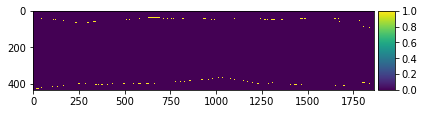

In [12]:
io.imshow(epi_both[200,:,:])
io.show()

In [13]:
# Generate a binary stack with the pixels inside the new epidermis set equal to 1
epi_in = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in.shape[2]):
    for z in range(0,epi_in.shape[0]):
        epi_in[z,e_up[z,y]:e_low[z,y],y] = 1
        
# Generate a binary stack with the pixels outside the new epidermis set equal to 1
epi_out = (epi_in==0)*1

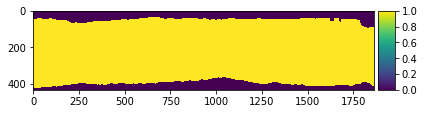

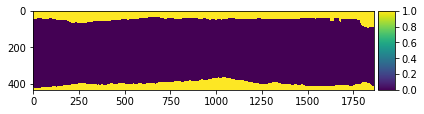

In [14]:
value2 = 200
io.imshow(epi_in[value2,:,:])
io.show()
io.imshow(epi_out[value2,:,:])
io.show()

In [15]:
# Set all background identified as IAS that lies outside epidermal boundaries as BG
# Set all IAS identified as BG that lies within epidermal boundaries as IAS
img2 = np.array(img, copy=True)
img2[(img2==ias)*(epi_out==1)] = bg
img2[(img2==palisade)*(epi_out==1)] = bg
img2[(img2==spongy)*(epi_out==1)] = bg
img2[(img2==vein)*(epi_out==1)] = bg
img2[(img2==bg)*(epi_in==1)] = ias

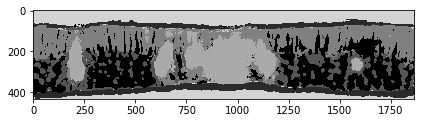

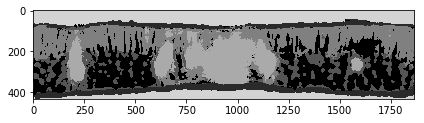

In [16]:
x = 10
io.imshow(img[x,:,:])
io.show()
io.imshow(img2[x,:,:])
io.show()

In [17]:
vein_trace = (img2==vein)

# Remove 'dangling' vein pixels
vein_rmv_parts = np.array(vein_trace, copy=True)
for i in range(0,vein_rmv_parts.shape[0]):
    vein_rmv_parts[i,:,:] = remove_small_objects(vein_trace[i,:,:], min_size=600)

# Write an array of just the removed particles
vein_parts = vein_trace ^ vein_rmv_parts 

# Replace small vein parts with spongy mesophyll
img2[vein_parts==1] = spongy

# Smooth veins with a double percent filter
vein_trace_pct = np.apply_along_axis(dbl_pct_filt, 0, arr = vein_rmv_parts)
invert_vt_pct = np.invert(vein_trace_pct)

#Set all spongy mesophyll identified as vein that lies oustide vein boundary as spongy mesophyll
img3 = np.array(img2, copy=True)
img3[(img3==vein)*(invert_vt_pct==1)] = spongy
#Set all vein identified as palisade or spongy that lies inside vein boundary as vein
img3[(img3==palisade)*(vein_trace_pct==1)] = vein
img3[(img3==spongy)*(vein_trace_pct==1)] = vein

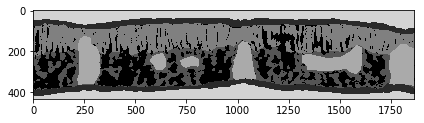

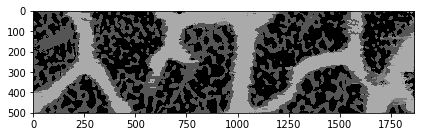

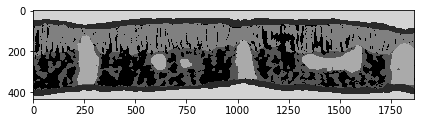

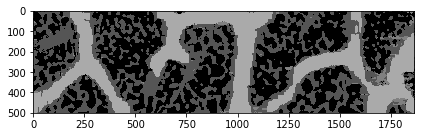

In [18]:
z = 250
y = 245
io.imshow(img2[z,:,:])
io.show()
io.imshow(img2[:,y,:])
io.show()
io.imshow(img3[z,:,:])
io.show()
io.imshow(img3[:,y,:])
io.show()

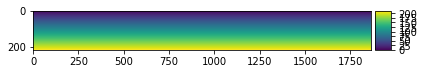

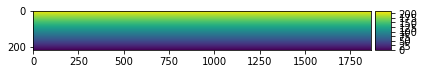

In [38]:
# Define 3D array of distances from lower value of img.shape[1] to median value# Define  
rangeA = range(0,img3.shape[1]/2)
tileA = np.tile(rangeA,(img3.shape[2],img3.shape[0],1))
tileA = np.moveaxis(tileA,[0,1,2],[2,0,1])
tileB = np.flip(tileA,1)
io.imshow(tileA[0,:,:])
io.show()
# # Define 3D array of distances from upper value of image.shape[1] to median value
# rangeB = range(img3.shape[1]/2,img3.shape[1])
# tileB = np.tile(rangeB,(img3.shape[2],img3.shape[0],1))
# tileB = np.moveaxis(tileB,[0,1,2],[2,0,1])
# # tileB = np.flip(tileB,1)
io.imshow(tileB[0,:,:])
io.show()

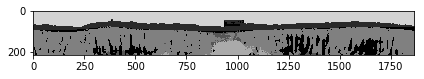

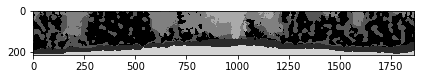

In [20]:
hold = img3.shape[1]/2
img3conc1 = np.array(img3[:,0:hold,:], copy = True) 
img3conc2 = np.array(img3[:,hold:img3.shape[1],:], copy = True)
io.imshow(img3conc1[0,:,:])
io.show()
io.imshow(img3conc2[0,:,:])
io.show()

In [74]:
hold = img3.shape[1]/2

# Determine the inner edge of the upper spongy
c = (img3conc1==spongy)
d = (tileA*c)
s_up_in = np.argmin(d, axis=1)
s_up_in_adjust = np.array(s_up_in, copy=True)
s_up_in_adjust[(s_up_in==0)] = hold

# Determine the inner edge of the upper palisade
c = (img3conc1==palisade)
d = (tileA*c)
p_up_in = np.argmin(d, axis=1)
p_up_in_adjust = np.array(p_up_in, copy=True)
p_up_in_adjust[(p_up_in==0)] = hold

# Determine the inner edge of the upper ias
c = (img3conc1==ias)
d = (tileA*c)
ias_up_in = np.argmin(d, axis=1)
ias_up_in_adjust = np.array(ias_up_in, copy=True)
ias_up_in_adjust[(ias_up_in==0)] = hold

# Determine the inner edge of the upper vein
c = (img3conc1==vein)
d = (tileA*c)
v_up_in = np.argmin(d, axis=1)
v_up_in_adjust = np.array(v_up_in, copy=True)
v_up_in_adjust[(v_up_in==0)] = hold

# Determine the inner edge of the upper epidermis
c = (img3conc1==epidermis)
d = (tileA*c)
e_up_in = np.argmax(d, axis=1)

e_up_in = np.minimum(e_up_in, s_up_in_adjust)
e_up_in = np.minimum(e_up_in, p_up_in_adjust)
e_up_in = np.minimum(e_up_in, ias_up_in_adjust)
e_up_in = np.minimum(e_up_in, v_up_in_adjust)

epi_up_in = np.zeros(img.shape)
for z in range(0,epi_up_in.shape[0]):
    for x in range(0,epi_up_in.shape[2]):
        if x > 1:
            if e_up_in[z,x]==0 or e_up_in[z,x]==hold:
                e_up_in[z,x] = e_up_in[z,x-1]
                epi_up_in[z,e_up_in[z,x],x] = 1
            else:
                epi_up_in[z,e_up_in[z,x],x] = 1
        else:
            epi_up_in[z,e_up_in[z,x],x] = 1

# Determine the lower edge of the spongy mesophyll
c = (img3conc2==spongy)
d = (tileB*c)
s_low_in = np.argmin(d, axis=1)

# Determine the lower edge of the palisade mesophyll
c = (img3conc2==palisade)
d = (tileB*c)
p_low_in = np.argmin(d, axis=1)

# Determins the lower edge of vein
c = (img3conc2==vein)
d = (tileB*c)
v_low_in = np.argmin(d,axis=1)

# Determine the lower edge of ias
c = (img3conc2==ias)
d = (tileB*c)
ias_low_in = np.argmin(d, axis=1)

#Determine the inner edge of the lower epidermis
c = (img3conc2==epidermis)
d = (tileB*c)
e_low_in = np.argmax(d, axis=1)
e_low_in_adjust = np.array(e_low_in, copy=True)
e_low_in_adjust[(e_low_in==hold)] = 0

e_low_in = np.maximum(e_low_in_adjust, s_low_in)
e_low_in = np.maximum(e_low_in_adjust, p_low_in)
e_low_in = np.maximum(e_low_in_adjust, ias_low_in)
e_low_in = np.maximum(e_low_in_adjust, v_low_in)

epi_low_in = np.zeros(img.shape)
for z in range(0,epi_low_in.shape[0]):
    for x in range(0,epi_low_in.shape[2]):
        epi_low_in[z,e_low_in[z,x]+hold-1,x] = 1
        
#add lower and upper halves
epi_inner_trace = np.add(epi_low_in,epi_up_in)

In [75]:
u = 10
i = 245
print(e_up_in[u,i])
# print(e_up_in_adjust[u,i])
print(v_up_in_adjust[u,i])
print(s_up_in_adjust[u,i])
print(p_up_in[u,i])
print(p_up_in_adjust[u,i])
print(ias_up_in_adjust[u,i])

81
216
216
0
216
216


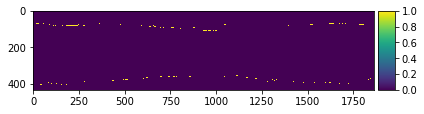

In [76]:
# io.imshow(epi_inner_trace[19,0:200,:270])
# io.show()
io.imshow(epi_inner_trace[19,:,:])
io.show()

In [77]:
# Generate a binary stack with the pixels inside the inner epidermis trace set equal to 1
epi_inner_up = np.zeros(img3conc1.shape, dtype=np.uint16)
for y in range(0,epi_inner_up.shape[2]):
    for z in range(0,epi_inner_up.shape[0]):
        epi_inner_up[z,:e_up_in[z,y],y] = 1

epi_inner_down = np.zeros(img3conc2.shape, dtype=np.uint16)
for y in range(0,epi_inner_down.shape[2]):
    for z in range(0,epi_inner_down.shape[0]):
        epi_inner_down[z,:e_low_in[z,y],y] = 1
epi_inner_down = (epi_inner_down==0)*1
        
# # Generate a binary stack with the pixels outside the new epidermis set equal to 1
# epi_inner_invert = (epi_inner==0)*1

#add lower and upper halves
# epi_inner_fill = np.concatenate((epi_inner_down,epi_inner_up), axis = 1)
epi_inner_fill = np.concatenate((epi_inner_up,epi_inner_down), axis = 1)
epi_inner_fill_invert = (epi_inner_fill==0)*1

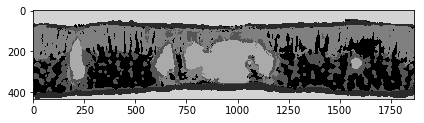

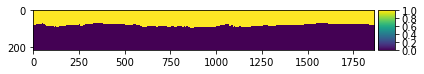

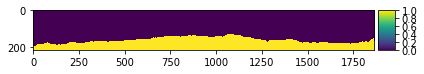

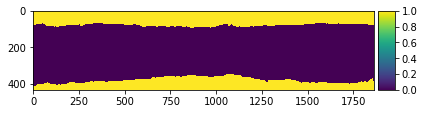

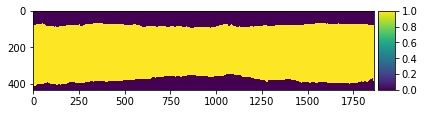

In [78]:
m = 10
io.imshow(img3[m,:,:])
io.show()
io.imshow(epi_inner_up[m,:,:])
io.show()
io.imshow(epi_inner_down[m,:,:])
io.show()
io.imshow(epi_inner_fill[m,:,:])
io.show()
io.imshow(epi_inner_fill_invert[m,:,:])
io.show()

In [81]:
# Set all background identified as IAS that lies outside epidermal boundaries as BG
# Set all IAS identified as BG that lies within epidermal boundaries as IAS
img4 = np.array(img3, copy=True)
img4[(img3==ias)*(epi_inner_fill==1)] = bg
img4[(img3==bg)*(epi_inner_fill_invert==1)] = ias
# img4[(img4==ias)*(epi_out==1)] = bg

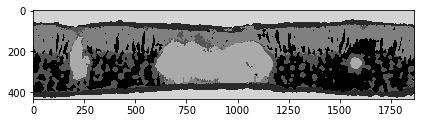

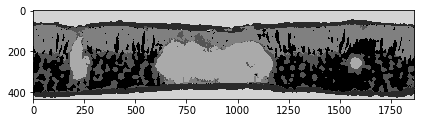

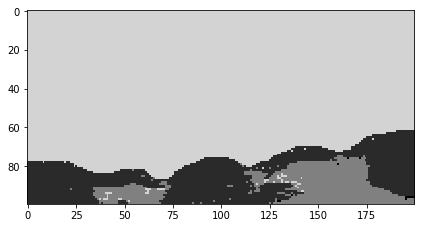

In [83]:
x = 28
io.imshow(img3[x,:,:])
io.show()
io.imshow(img4[x,:,:])
io.show()
io.imshow(img4[x,0:100,900:1100])
io.show()

In [84]:
# Save post-processed predicted stack
io.imsave(filepath+results_folder+'/prediction_postprocess_new.tif', img4)